In [9]:
!kaggle datasets download -d ambarish/breakhis --unzip -p /content/breakhis_data


Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
100% 3.98G/3.99G [00:41<00:00, 257MB/s]
100% 3.99G/3.99G [00:41<00:00, 103MB/s]


In [10]:
base_path = "/content/breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
print(os.listdir(base_path))


['malignant', 'count_files.sh', 'README.txt', 'benign']


In [11]:
import os
import shutil
import glob
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --------- 1. Préparation dataset ---------
def prepare_dataset_3way(src_root, dst_root, split_train=0.6, split_val=0.2):
    classes = ["benign", "malignant"]  # adapte si besoin
    for cls in classes:
        all_imgs = glob.glob(f"{src_root}/{cls}/**/*.png", recursive=True)
        random.shuffle(all_imgs)
        n = len(all_imgs)
        train_end = int(n * split_train)
        val_end = train_end + int(n * split_val)

        for i, img_path in enumerate(all_imgs):
            if i < train_end:
                set_type = "train"
            elif i < val_end:
                set_type = "val"
            else:
                set_type = "test"

            dst_dir = os.path.join(dst_root, set_type, cls)
            os.makedirs(dst_dir, exist_ok=True)
            shutil.copy(img_path, os.path.join(dst_dir, os.path.basename(img_path)))

# Appel de la préparation (modifie les chemins si besoin)
prepare_dataset_3way(
    src_root="/content/breakhis_data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast",
    dst_root="/content/breakhis_data",
    split_train=0.6,
    split_val=0.2
)

# --------- 2. Création des DataLoaders ---------

BATCH_SIZE = 32
IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Utilise la nouvelle taille
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder("/content/breakhis_data/train", transform=train_transform)
val_data = datasets.ImageFolder("/content/breakhis_data/val", transform=val_test_transform)
test_data = datasets.ImageFolder("/content/breakhis_data/test", transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Nombre d'images : train={len(train_data)}, val={len(val_data)}, test={len(test_data)}")


Nombre d'images : train=4745, val=1581, test=1583


In [21]:
import torch
import torch.nn as nn
import torchvision.models as models

class DeepCNNPretrained(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super().__init__()
        self.backbone = models.mobilenet_v2(pretrained=pretrained)

        in_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        logits = self.backbone(x)
        # Si sortie binaire, retourner sigmoid, sinon logits pour CrossEntropy
        if logits.shape[1] == 1:
            return torch.sigmoid(logits)
        else:
            return logits


In [22]:
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepCNNPretrained(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(train_loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # labels : LongTensor (batch_size,)
        optimizer.zero_grad()
        outputs = model(images)  # shape: (batch_size, 8)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def validate(val_loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


Epoch 1/5 — Loss: 1.6188 | Train Acc: 0.4851 | Val Loss: 1.2703 | Val Acc: 0.8786
Epoch 2/5 — Loss: 0.9864 | Train Acc: 0.8607 | Val Loss: 0.7909 | Val Acc: 0.9285
Epoch 3/5 — Loss: 0.6526 | Train Acc: 0.9224 | Val Loss: 0.5104 | Val Acc: 0.9412
Epoch 4/5 — Loss: 0.4600 | Train Acc: 0.9380 | Val Loss: 0.3591 | Val Acc: 0.9538
Epoch 5/5 — Loss: 0.3461 | Train Acc: 0.9482 | Val Loss: 0.2725 | Val Acc: 0.9557


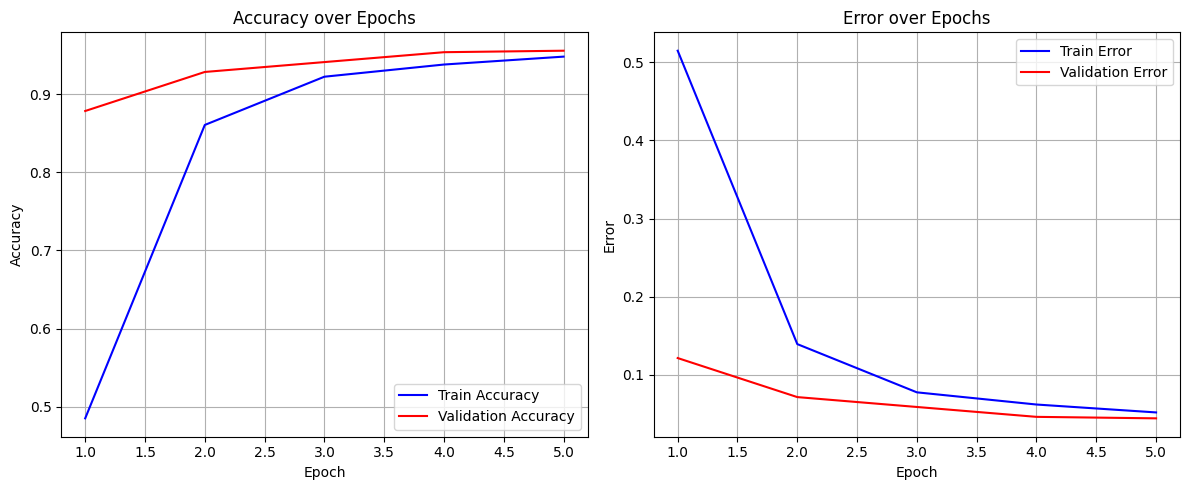

In [23]:
import matplotlib.pyplot as plt

EPOCHS = 5

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Entraînement une seule fois
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = validate(val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} — "
          f"Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Ensuite, quand tu veux tracer les courbes, tu peux faire :

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy over Epochs')

plt.subplot(1,2,2)
plt.plot(epochs, [1 - acc for acc in train_accuracies], 'b-', label='Train Error')
plt.plot(epochs, [1 - acc for acc in val_accuracies], 'r-', label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title('Error over Epochs')

plt.tight_layout()
plt.show()


In [24]:
def test():
    model.eval()   # 1
    correct, total = 0, 0  # 2

    with torch.no_grad():  # 3
        for images, labels in test_loader:  # 4
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)  # 5
            outputs = model(images)  # 6
            preds = (torch.sigmoid(outputs) > 0.5).float()  # 7
            correct += (preds == labels).sum().item()  # 8
            total += labels.size(0)  # 9

    accuracy = correct / total  # 10
    print(f"Test Accuracy: {accuracy:.4f}")  # 11
    return accuracy  # 12


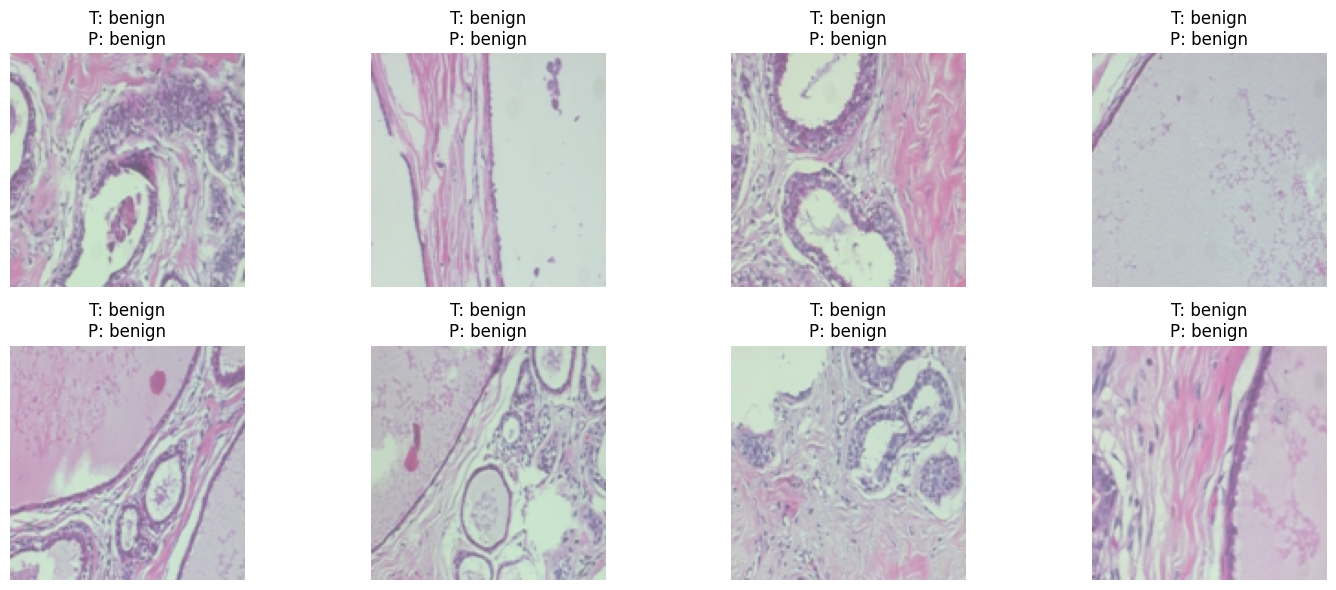

In [25]:
import matplotlib.pyplot as plt
import torch

def imshow(img, title=None):
    # img : tensor CxHxW, normalisé avec ImageNet stats
    img = img.cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean  # dénormalisation
    img = torch.clamp(img, 0, 1)  # éviter les valeurs hors [0,1]
    img = img.permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def show_predictions(model, dataloader, device, class_names, n_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Cas classification binaire (num_classes=1)
            if outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).long().squeeze(1)
            else:
                # Multi-classes
                preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown == n_images:
                    plt.tight_layout()
                    plt.show()
                    return
                plt.subplot(2, n_images // 2, images_shown + 1)
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                title = f"T: {true_label}\nP: {pred_label}"
                imshow(images[i], title)
                images_shown += 1

    plt.tight_layout()
    plt.show()

# Exemple d’appel
class_names = ['benign', 'malignant']  # adapte selon tes classes
show_predictions(model, test_loader, device, class_names, n_images=8)
